# Poisson Regression
- This notebook does a poisson regression model for region 197, 54, and all regions.  
- Region 54 is included, because it was determined to have the strongest correlation in the [PCALinearRegression](PCALinearRegressionFinal.ipynb) notebook.  This way we can compare linear and poisson models.
- Region 197 is included, because it has the highest magnitude event and was used in the [Time_Series](Time_Series.ipynb) notebook.
- Then a model is run on all regions using the first 15 years (1999-2013) to train the model and the last 5 years (2014-2018) to test it.

## Initialize Data
First we load the data, perform some data carpentry, and find the top ten Flinn-Engdahl regions by highest magnitude

In [1]:
source('initialize_data.R', echo = FALSE)

In [2]:
suppressWarnings(suppressMessages(load_libraries()))

[1] "libraries loaded successfully"


In [3]:
path <- "~/jupyter/cs2019_Group11/GroupProducts/data" #Explicit location of data

#we run all the previously created functions
df <- loadFiles(path) %>%
    reqCols %>%
    parseDt('time')

Files in "~/jupyter/cs2019_Group11/GroupProducts/data" loaded.
Subset Completed.
Parsed column: time.


In [4]:
#Reads in new data csv files 
tpts <- read.csv(file="data.csv", header=TRUE, sep=",")
head(tpts)

X,newname,depth,mag,time,id,updated,latitude,longitude,bvalue,error,time_lag
1,10,33.0,5.1,1999-02-14 17:17:27,usp00092tz,2014-11-07 01:07:01,21.581,-106.681,0.6204207,0.66570086,NA
2,10,33.0,4.5,1999-03-16 06:14:07,usp00094kr,2014-11-07 01:07:14,22.002,-107.375,0.6204207,0.66570086,1999-02-14 17:17:27
3,10,10.0,4.5,1999-01-13 07:38:50,usp0009114,2014-11-07 01:06:48,22.690,-107.988,0.6204207,0.66570086,1999-03-16 06:14:07
4,10,10.0,5.3,1999-03-12 07:07:40,usp00094by,2016-11-09 22:04:11,22.219,-107.368,0.6204207,0.66570086,1999-01-13 07:38:50
5,10,33.0,5.2,1999-01-10 20:36:06,usp00090x3,2016-11-09 21:38:36,22.939,-108.020,0.6204207,0.66570086,1999-03-12 07:07:40
6,100,129.1,4.3,1999-04-15 14:05:21,usp00096bk,2014-11-07 01:07:28,-19.295,-69.268,0.3347563,0.04778564,NA


In [5]:
#Elysa
#Reduce data down to time columns, I was unable to convert the time column from the CSV file to a POSIXct
df = df[ -c(1:5, 7) ]
head(df)

id,time_Date,time_Time,time_Year
usp0009awp,1999-07-01,18:29:27,1999
uw10474128,1999-07-01,17:10:51,1999
usp0009awk,1999-07-01,16:42:41,1999
usp0009awh,1999-07-01,15:50:11,1999
usp0009awf,1999-07-01,14:52:19,1999
usp0009awe,1999-07-01,14:52:12,1999


In [6]:
#Elysa
#Final Cleaning of data for PCA
#Remove uneeded columns and merges time data frame values 
tpts_df = as.data.frame(tpts)
tpts_df$X = NULL
tpts_df$time = NULL
tpts_df[is.na(tpts_df)] = 0
bvalue_df <- merge(tpts_df, df, by = 'id')
head(bvalue_df)

id,newname,depth,mag,updated,latitude,longitude,bvalue,error,time_lag,time_Date,time_Time,time_Year
ak00210oudoo,565,87.5,2.5,2019-02-12 16:26:52,63.1622,-149.6963,0.6433992,0.48815573,2002-03-25 06:03:03,2002-01-22,12:51:05,2002
ak0021221pwa,18,10.0,3.3,2019-02-12 16:27:01,54.3998,-160.7571,0.3158505,0.11982004,2002-03-16 04:07:20,2002-01-23,19:15:41,2002
ak002129q4mn,20,44.9,2.5,2019-02-12 16:26:57,59.9429,-149.7878,0.6113635,0.02304888,2002-08-28 11:33:20,2002-01-23,08:05:02,2002
ak00212ah915,565,7.7,3.1,2019-02-12 16:26:58,63.2605,-151.3179,0.6433992,0.48815573,2002-11-05 05:16:11,2002-01-23,09:31:57,2002
ak00213vjuuf,18,16.6,3.1,2019-02-12 16:27:06,55.4264,-158.4416,0.3158505,0.11982004,2002-06-11 04:22:38,2002-01-24,05:17:53,2002
ak00213y0rgf,37,13.2,3.7,2019-02-12 16:27:07,60.2080,-139.4049,0.6300175,0.05132107,2002-09-01 19:07:24,2002-01-24,09:32:33,2002


In [7]:
#Bill
#finding top ten Flinn-Engdahl regions by max magnitude occuring in that region

#grouping and summarising by max mag
tpts_df_mm = tpts_df %>% group_by(newname) %>% summarise(max(mag))

#changing column name to max_mag for easier use
colnames(tpts_df_mm) <- c('newname', 'max_mag')

#ordering by descending max_mag
tpts_df_mm = arrange(tpts_df_mm, desc(max_mag))

#displaying top then regions and their max_mags
top_ten_mag_regions = head(tpts_df_mm, 10)
top_ten_mag_regions

newname,max_mag
197,9.1
570,9.1
54,8.8
593,8.6
65,8.4
191,8.4
171,8.3
553,8.3
669,8.3
60,8.2


In [8]:
#Elysa
#Finds the unique values of the highest magnitude regions in the dataframe 
regions = unique(top_ten_mag_regions$newname)
regions

[1] 197 570  54 593  65 191 171 553 669  60

In [9]:
#Elysa 
#Now I will make 10 dataframes with only numeric data for multiple linear regression for each highest magnitude region
for (i in c(1,2,3,4,5,6,7,8,9,10)) {
  assign(paste0("lindf_", regions[i]), subset(bvalue_df, newname == regions[i],select=c(depth,mag,latitude,longitude,time_Year,time_Time,bvalue)) )
  #print(i)
  #print(paste("region: ", regions[i]))
}
head(lindf_54)
str(lindf_54)

,depth,mag,latitude,longitude,time_Year,time_Time,bvalue
73612,20.00,6.0,-37.8780,-73.5450,2010,04:30:10,0.2824985
90072,22.90,8.8,-36.1220,-72.8980,2010,00:34:11,0.2824985
102599,14.20,4.6,-36.1720,-73.0910,2015,04:50:43,0.2824985
102613,33.60,3.9,-32.6990,-71.4760,2015,19:22:02,0.2824985
102908,40.72,4.2,-29.5424,-71.6619,2015,18:43:52,0.2824985
102962,13.00,6.2,-36.1167,-73.5219,2015,13:27:29,0.2824985


'data.frame':	10824 obs. of  7 variables:
 $ depth    : num  20 22.9 14.2 33.6 40.7 ...
 $ mag      : num  6 8.8 4.6 3.9 4.2 6.2 5.4 4.8 4.7 4.6 ...
 $ latitude : num  -37.9 -36.1 -36.2 -32.7 -29.5 ...
 $ longitude: num  -73.5 -72.9 -73.1 -71.5 -71.7 ...
 $ time_Year: num  2010 2010 2015 2015 2015 ...
 $ time_Time: 'ITime' int  04:30:10 00:34:11 04:50:43 19:22:02 18:43:52 13:27:29 14:07:49 15:09:09 17:01:56 14:29:17 ...
 $ bvalue   : num  0.282 0.282 0.282 0.282 0.282 ...


## Region 54 Model
Next we will split the data into training and testing portions, train the Poisson regression model, use it to predict magnitudes, and compare the predictions with the actual results.

In [10]:
#Bill
#splitting into train/test

#using region 54 as it was determined to give the best predictive results 
#in the correlation matrix done in PCALinearRegressionFinal.ipynb
train54 = subset(lindf_54, time_Year >= 1999 & time_Year < 2013)
test54 = subset(lindf_54, time_Year >= 2014)

In [11]:
#Bill
#train the Poisson model using all available attributes
m54 <- suppressWarnings(glm(mag ~ ., family=poisson(link="log"), data = train54))
summary(m54)


Call:
glm(formula = mag ~ ., family = poisson(link = "log"), data = train54)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.78542  -0.24741  -0.00743   0.20691   1.89096  

Coefficients: (1 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.203e+01  3.249e+00  -9.857  < 2e-16 ***
depth        1.032e-03  3.232e-04   3.192  0.00141 ** 
latitude     1.218e-02  4.193e-03   2.906  0.00367 ** 
longitude   -1.472e-01  1.501e-02  -9.806  < 2e-16 ***
time_Year    1.153e-02  1.708e-03   6.753 1.45e-11 ***
time_Time   -9.453e-08  2.123e-07  -0.445  0.65620    
bvalue              NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 1337.45  on 9364  degrees of freedom
Residual deviance:  986.05  on 9359  degrees of freedom
AIC: Inf

Number of Fisher Scoring iterations: 4


In [12]:
#Bill
#predict magnitudes
pm54 = predict(m54, newdata=test54, type="response")

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

In [13]:
#Bill
#Checking to make sure the test set and prediction set are the same length (and different than the train set)
nrow(train54)
nrow(test54)
length(pm54)

[1] 9365

[1] 1361

[1] 1361

In [14]:
#Bill
#Adding the predicted values to the rest of the test data set
test54$pred <- round(pm54,1)
head(test54)

,depth,mag,latitude,longitude,time_Year,time_Time,bvalue,pred
102599,14.20,4.6,-36.1720,-73.0910,2015,04:50:43,0.2824985,4.6
102613,33.60,3.9,-32.6990,-71.4760,2015,19:22:02,0.2824985,3.9
102908,40.72,4.2,-29.5424,-71.6619,2015,18:43:52,0.2824985,4.2
102962,13.00,6.2,-36.1167,-73.5219,2015,13:27:29,0.2824985,4.9
102964,10.00,5.4,-36.0507,-73.6406,2015,14:07:49,0.2824985,5.0
102966,27.80,4.8,-36.0430,-73.7590,2015,15:09:09,0.2824985,5.2


In [15]:
#Elysa and Jessica
#Creating a new dataframe for visualizations that contains only necessary values for chart
d54 = test54[c(2,8)]
d54$id = seq.int(nrow(d54)) 
diff = d54$mag - d54$pred
d54$diff = diff
head(d54)

,mag,pred,id,diff
102599,4.6,4.6,1,0.0
102613,3.9,3.9,2,0.0
102908,4.2,4.2,3,0.0
102962,6.2,4.9,4,1.3
102964,5.4,5.0,5,0.4
102966,4.8,5.2,6,-0.4


In [16]:
#Elysa and Jessica
#Finding average values for region 54 for comparison to put on visualizations 
avgmag54 = mean(d54$mag)
avgmag54
avgpred54 = mean(d54$pred)
avgpred54
avgdiff54 = mean(d54$diff)
avgdiff54

[1] 4.445261

[1] 4.205952

[1] 0.2393093

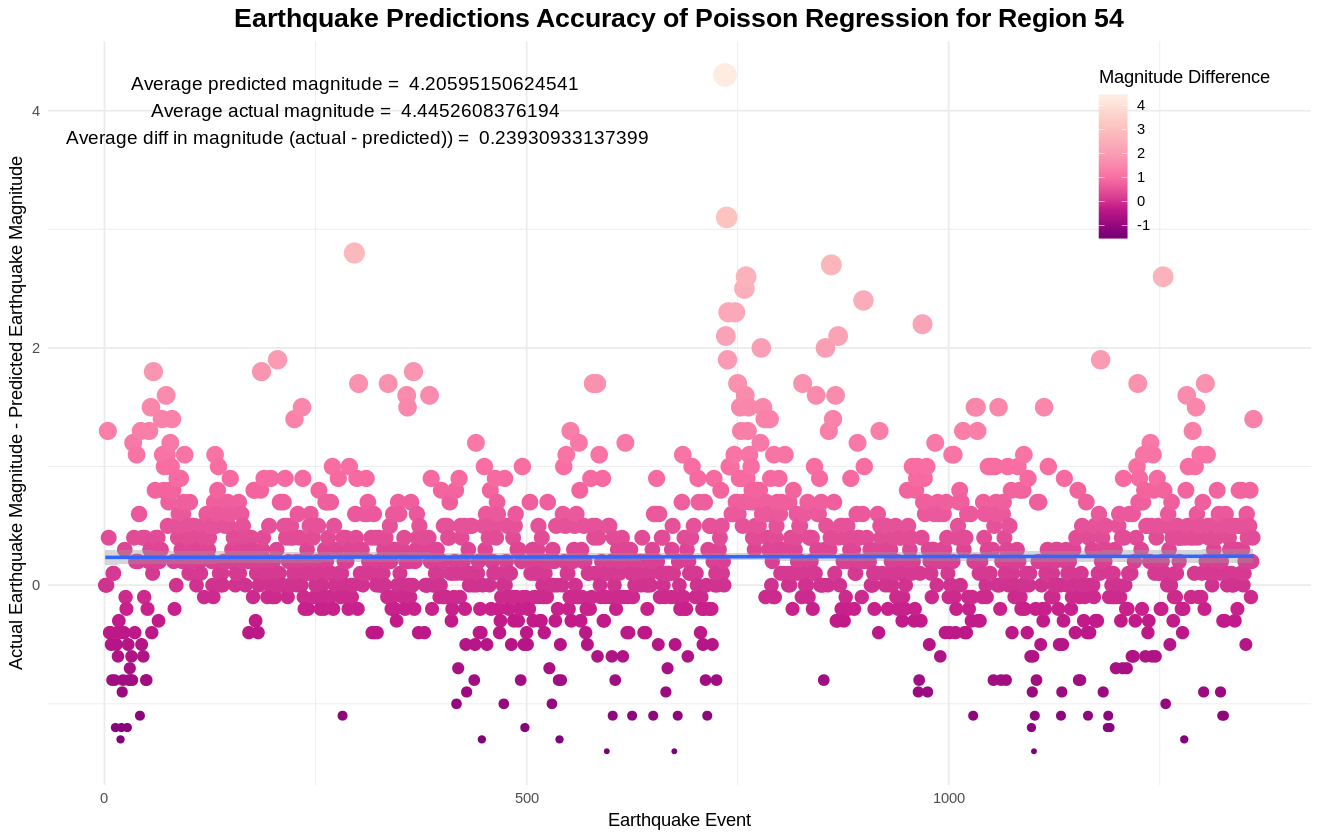

In [17]:
#Jessica 
options(repr.plot.width=11, repr.plot.height=7)#change size 
labels = paste("Average predicted magnitude = ", avgpred54, "\nAverage actual magnitude = ", avgmag54, "\nAverage diff in magnitude (actual - predicted)) = ", avgdiff54)
#add average values

ggplot(d54, aes(x = id, y = diff, color = diff, size = diff))+#add data
scale_color_distiller(palette = "RdPu") + #choise a pretty color scheme
theme_minimal()+ #make look nice
theme(legend.position = c(.9, .85))+ #move legend
geom_point()+#add points
#add trend line
geom_smooth(method = "lm")+
#get ride of size legend
guides(size = FALSE)+
annotate("text", x = 300, y = 4, label = labels, size=4)+ #position text
#relabels
xlab("Earthquake Event") + 
labs(color = "Magnitude Difference")+
ylab("Actual Earthquake Magnitude - Predicted Earthquake Magnitude") +
ggtitle("Earthquake Predictions Accuracy of Poisson Regression for Region 54") +
# I give a proper title

theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))

## Region 197 Model
We will now do the same for the Flinn-Engdahl region 197

In [18]:
#Bill
#splitting into train/test

#now using region 197 as it had the highest magnitude event
#training on first 10 years and testing on 2008 only in order to compare to the time series model in Time_Series.ipynb
train197 = subset(lindf_197, time_Year >= 1999 & time_Year < 2008)
test197 = subset(lindf_197, time_Year = 2008)


In [19]:
#Bill
#train the Poisson model using all available attributes
m197 <- suppressWarnings(glm(mag ~ ., family=poisson(link="log"), data = train197))
summary(m197)


Call:
glm(formula = mag ~ ., family = poisson(link = "log"), data = train197)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.70221  -0.13452  -0.01122   0.09768   1.22532  

Coefficients: (1 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)  
(Intercept)  2.285e+01  1.297e+01   1.762   0.0780 .
depth       -5.350e-04  7.132e-04  -0.750   0.4532  
latitude     5.136e-03  1.429e-02   0.359   0.7194  
longitude   -8.248e-03  3.462e-02  -0.238   0.8117  
time_Year   -1.018e-02  5.999e-03  -1.697   0.0897 .
time_Time    3.845e-07  6.100e-07   0.630   0.5285  
bvalue              NA         NA      NA       NA  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 66.482  on 1036  degrees of freedom
Residual deviance: 62.673  on 1031  degrees of freedom
AIC: Inf

Number of Fisher Scoring iterations: 4


In [20]:
#Bill
#predict magnitudes
pm197 = predict(m197, newdata=test197, type="response")

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

In [21]:
#Bill
#Checking to make sure the test set and prediction set are the same length (and different than the train set)
nrow(train197)
nrow(test197)
length(pm197)

[1] 1037

[1] 5364

[1] 5364

In [22]:
#Bill
#Adding the predicted values to the rest of the test data set
test197$pred <- round(pm197,1)
head(test197)

,depth,mag,latitude,longitude,time_Year,time_Time,bvalue,pred
90073,29.00,9.1,38.2970,142.3730,2011,23:46:24,0.3161679,4.1
102540,34.97,4.1,37.7608,141.8975,2015,18:29:18,0.3161679,3.9
102565,28.62,4.1,35.3013,141.4792,2015,13:42:06,0.3161679,3.9
102601,40.61,4.9,37.3195,141.5104,2015,06:02:40,0.3161679,3.9
102633,60.89,4.1,37.6135,141.4243,2015,00:53:53,0.3161679,3.8
102861,99.36,4.3,35.7541,140.0651,2015,09:48:26,0.3161679,3.8


In [23]:
#Elysa and Jessica
#Creating a new dataframe for visualizations that contains only necessary values for chart
d197 = test197[c(2,8)]
d197$id = seq.int(nrow(d197)) 
diff = d197$mag - d197$pred
d197$diff = diff
head(d197)

,mag,pred,id,diff
90073,9.1,4.1,1,5.0
102540,4.1,3.9,2,0.2
102565,4.1,3.9,3,0.2
102601,4.9,3.9,4,1.0
102633,4.1,3.8,5,0.3
102861,4.3,3.8,6,0.5


In [24]:
#Elysa and Jessica
#Finding average values for region 54 for comparison to put on visualizations 
avgmag197 = mean(d197$mag)
avgmag197
avgpred197 = mean(d197$pred)
avgpred197
avgdiff197 = mean(d197$diff)
avgdiff197

[1] 4.545749

[1] 4.072837

[1] 0.472912

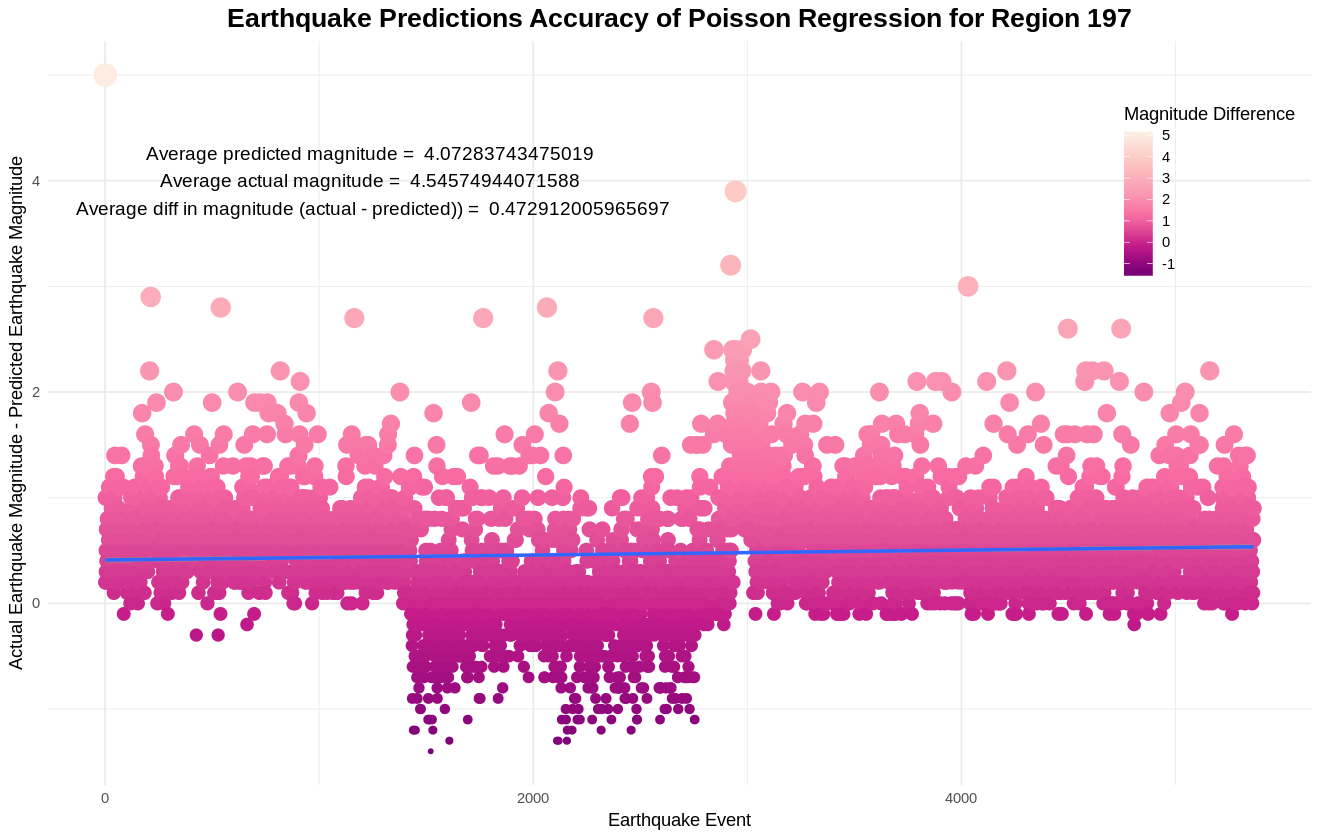

In [25]:
#Jessica 
options(repr.plot.width=11, repr.plot.height=7)#change size 
labels = paste("Average predicted magnitude = ", avgpred197, "\nAverage actual magnitude = ", avgmag197, "\nAverage diff in magnitude (actual - predicted)) = ", avgdiff197)
#add average values

ggplot(d197, aes(x = id, y = diff, color = diff, size = diff))+#add data
scale_color_distiller(palette = "RdPu") + #choise a pretty color scheme
theme_minimal()+ #make look nice
theme(legend.position = c(.92, .8))+ #move legend
geom_point()+#add points
#add trend line
geom_smooth(method = "lm")+
#get ride of size legend
guides(size = FALSE)+
annotate("text", x = 1250, y = 4, label = labels, size=4)+ #position text
#relabels
xlab("Earthquake Event") + 
labs(color = "Magnitude Difference")+
ylab("Actual Earthquake Magnitude - Predicted Earthquake Magnitude") +
ggtitle("Earthquake Predictions Accuracy of Poisson Regression for Region 197") +
# I give a proper title

theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))

## All Region Model
We will now do the same using a data set containing all Flinn-Endahl regions

In [35]:
#Elysa 
#Creating an overall dataframe for linear regression with only necessary variables 
overallLDF = bvalue_df[c(3,4,6:8,12,13)]
head(overallLDF)

depth,mag,latitude,longitude,bvalue,time_Time,time_Year
87.5,2.5,63.1622,-149.6963,0.6433992,12:51:05,2002
10.0,3.3,54.3998,-160.7571,0.3158505,19:15:41,2002
44.9,2.5,59.9429,-149.7878,0.6113635,08:05:02,2002
7.7,3.1,63.2605,-151.3179,0.6433992,09:31:57,2002
16.6,3.1,55.4264,-158.4416,0.3158505,05:17:53,2002
13.2,3.7,60.2080,-139.4049,0.6300175,09:32:33,2002


In [27]:
#Bill
#splitting into train/test

#now using all regions
#training on first 15 years and testing on last 5
trainAll = subset(overallLDF, time_Year >= 1999 & time_Year < 2013)
testAll = subset(overallLDF, time_Year >= 2013)


In [28]:
#Bill
#train the Poisson model using all available attributes
mAll <- suppressWarnings(glm(mag ~ ., family=poisson(link="log"), data = trainAll))
summary(mAll)


Call:
glm(formula = mag ~ ., family = poisson(link = "log"), data = trainAll)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.34467  -0.26177  -0.02754   0.20760   2.38458  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -8.428e+00  4.753e-01  -17.73  < 2e-16 ***
depth        2.041e-04  9.051e-06   22.55  < 2e-16 ***
latitude    -2.396e-03  3.044e-05  -78.71  < 2e-16 ***
longitude    7.517e-04  7.700e-06   97.62  < 2e-16 ***
bvalue      -6.867e-02  3.155e-03  -21.77  < 2e-16 ***
time_Time   -1.026e-07  3.538e-08   -2.90  0.00373 ** 
time_Year    4.905e-03  2.370e-04   20.70  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 63961  on 336641  degrees of freedom
Residual deviance: 39849  on 336635  degrees of freedom
AIC: Inf

Number of Fisher Scoring iterations: 4


In [29]:
#Bill
#predict magnitudes
pmAll = predict(mAll, newdata=testAll, type="response")

In [30]:
#Bill
#Checking to make sure the test set and prediction set are the same length (and different than the train set)
nrow(trainAll)
nrow(testAll)
length(pmAll)

[1] 336642

[1] 169602

[1] 169602

In [31]:
#Bill
#Adding the predicted values to the rest of the test data set
testAll$pred <- round(pmAll,1)
head(testAll)

,depth,mag,latitude,longitude,bvalue,time_Time,time_Year,pred
24845,18.3,2.5,51.6417,-178.4215,0.5083511,19:11:02,2013,3.2
24846,2.8,2.8,63.4415,-147.5797,0.6433992,22:29:54,2013,3.1
24847,13.1,2.5,51.5935,-178.4744,0.5083511,23:00:33,2013,3.1
24848,23.8,2.5,55.4876,-134.9487,0.6300175,23:54:47,2013,3.2
24849,64.6,2.8,59.6165,-152.4703,0.4375355,03:11:19,2013,3.2
24850,74.3,2.5,60.8516,-151.6655,0.6113635,05:22:18,2013,3.2


In [32]:
#Elysa and Jessica
#Creating a new dataframe for visualizations that contains only necessary values for chart
dAll = testAll[c(2,8)]
dAll$id = seq.int(nrow(dAll)) 
diff = dAll$mag - dAll$pred
dAll$diff = diff
head(dAll)

,mag,pred,id,diff
24845,2.5,3.2,1,-0.7
24846,2.8,3.1,2,-0.3
24847,2.5,3.1,3,-0.6
24848,2.5,3.2,4,-0.7
24849,2.8,3.2,5,-0.4
24850,2.5,3.2,6,-0.7


In [33]:
#Elysa and Jessica
#Finding average values for region 54 for comparison to put on visualizations 
avgmagAll = mean(dAll$mag)
avgmagAll
avgpredAll = mean(dAll$pred)
avgpredAll
avgdiffAll = mean(dAll$diff)
avgdiffAll

[1] 3.754758

[1] 3.918989

[1] -0.1642312

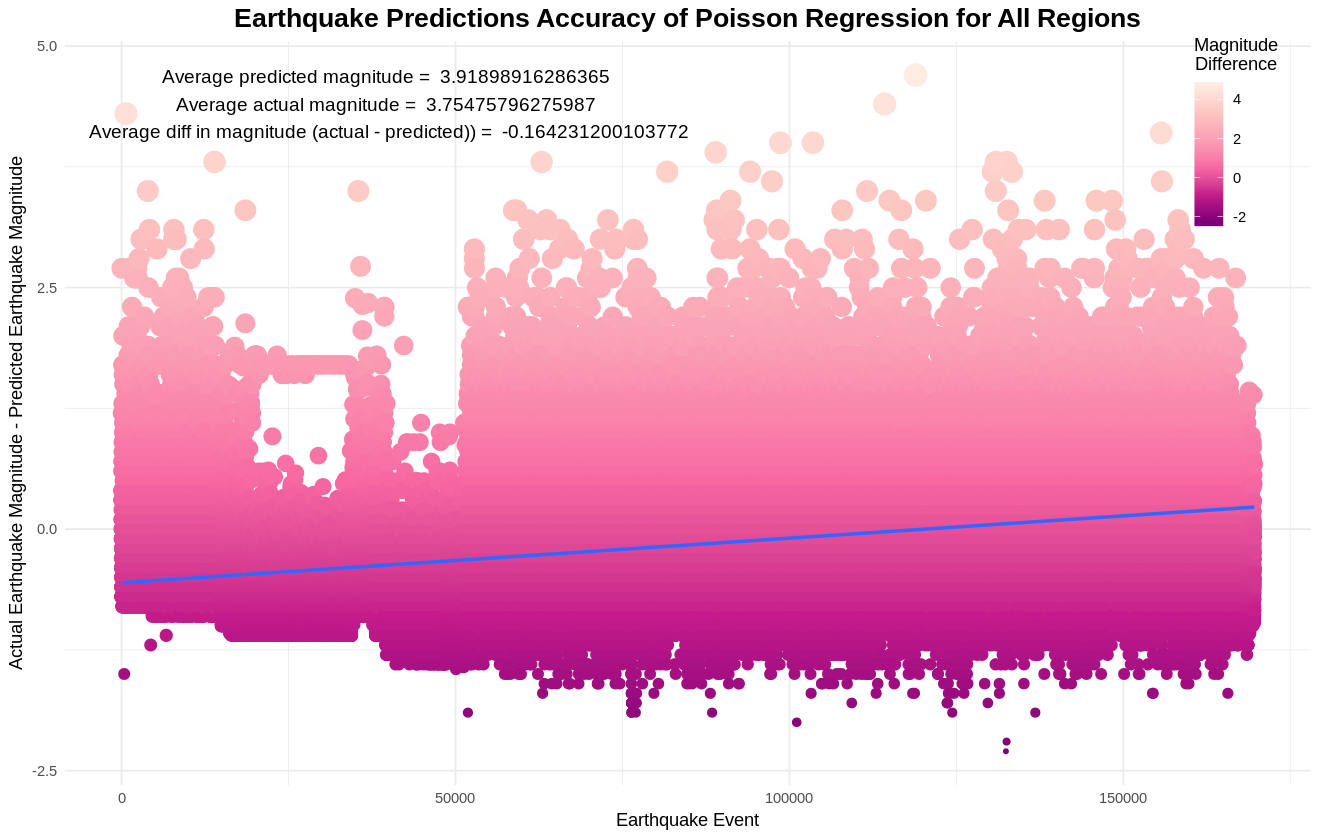

In [34]:
#Jessica 
options(repr.plot.width=11, repr.plot.height=7)#change size 
labels = paste("Average predicted magnitude = ", avgpredAll, "\nAverage actual magnitude = ", avgmagAll, "\nAverage diff in magnitude (actual - predicted)) = ", avgdiffAll)
#add average values

ggplot(dAll, aes(x = id, y = diff, color = diff, size = diff))+#add data
scale_color_distiller(palette = "RdPu") + #choose a pretty color scheme
theme_minimal()+ #make look nice
theme(legend.position = c(.94, .88), legend.title = element_text(hjust = 0.5))+ #move legend
geom_point()+#add points
#add trend line
geom_smooth(method = "lm")+
#get ride of size legend
guides(size = FALSE)+
annotate("text", x = 40000, y = 4.4, label = labels, size=4)+ #position text
#relabels
xlab("Earthquake Event") + 
labs(color = "Magnitude\nDifference")+
ylab("Actual Earthquake Magnitude - Predicted Earthquake Magnitude") +
ggtitle("Earthquake Predictions Accuracy of Poisson Regression for All Regions") +
# I give a proper title

theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))